# Building A Neural Network
PyTorch provides all of the most common parts that are required to cobble together a neural network. In this notebook we will take a look at each piece.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook

## Constructing the Model

The easiest way to build our model is to create a class which inherits PyTorch's `nn.Module` class. An `nn.Module` stores layer weights and has a method `.forward(input)` that will be called when doing the forward pass through the network. Modules provide a convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc. For this tutorial we will make a simple CNN for the MNIST dataset.  

The `__init__` function is were we declare the model weights. These could be plain torch tensors, but PyTorch also provides pre-built version of common layers, such as linear, convolutional, or recurrent layers.  

The `nn.Sequential` container class allows us to string together multiple operations that will be executed sequentially.

In the `.forward(input)` function we define how the model input will interact with the model weights. Although we don't use it in this example, we can use normal python control flow here to change how the model reacts to certain scenarios.

In [4]:
# Create a CNN model object
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=5,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, 
                      out_channels=64, 
                      kernel_size=5,
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))

        # PyTorch can't infer the number of inputs to layers (yet), 
        # so we need to manually calculate the number of outputs from the convolutional layers
        self.fc = nn.Linear(7 * 7 * 64, 10)  
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        
        # At least here we can use the .view function to infer the output size 
        # in order to flatten the convolutional layer output
        out = out.view(out.size(0), -1)  
        
        out = self.fc(out)
        # There is no need to add a softmax in the forward pass as it is included in the loss function
        return out
    
cnn = CNN()  # Instantiate the model
print(cnn)   # Printing the model will show us each of the layers

CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc): Linear (3136 -> 10)
)


## Loss Function
A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target. The PyTorch `nn` package provides a variety of different loss functions. We will use `nn.CrossEntropyLoss` which combines `LogSoftMax` and `NLLLoss` into a single class.

In [5]:
criterion = nn.CrossEntropyLoss()

## Optimizer
Now we need an optimizer to define our weight update rule. The PyTorch `optim` package provides a variety of the most common optimizers, such as SGD, RMSProp, and Adam. For this example we will use Adam.

We will need to provide the optimizer with all of the parameters that we want it to update, so in this case we will pass it all of the CNN parameters. 

The ability to control which parameters are updated can be extremely useful. For example, you can configure the optimizer to update different parts of your model with differet learning rates. Another use case would be for fine-tuning pretrained model, where you only need to update the parameters in the last layer. Multiple optimizers could also be used, such as in the case of training model with multiple parts such as GANs.

In [6]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

## Data Loading and Augmentation
Before we can train the network we need to have some data for it. The `torchvision` package provides data loaders for several of the most common datasets (MNIST, CIFAR, MS-COCO, etc.) as well as a generic data loader that can load images from a pre-defined folder structure.

Dataset preprocessing and augmentation can be added to the data loaders through the use of the `torchvision.transforms` package. Options include normalization, scaling, cropping, and flipping. The external `torchsample` library extends these options further with additional augmentation options.

In [7]:
# Define a list of transformations to be applied to each image
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = dsets.MNIST(root='data/',
                            train=True, 
                            transform=transforms,
                            download=True)

test_dataset = dsets.MNIST(root='data/',
                           train=False, 
                           transform=transforms)

# Data loaders define how the dataset is sampled
# They can be configured to use multiple threads if necessary
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=128, 
                                          shuffle=False)

Lets take a look at the images we've got. The `torchvision.utils.makegrid` function is great for this. Pass it a 4D tensor (B, C, H, W) and it returns a nice grid of images. 

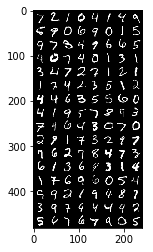

In [28]:
test_gen = iter(test_loader)
test_images, test_labels = test_gen.next()

image_grid = make_grid(test_images, normalize=True).numpy()  # We need to convert from torch tensor to numpy
image_grid = np.moveaxis(image_grid, 0, 2)                   # The chanel dimension is first, but we need it last
plt.imshow(image_grid)

## Training Loop
Now that we have all of the parts we can put them together in the training loop. For each batch in the training loop we will retrieve a batch of images and labels from the data loader and wrap them as Variables.

Next we will pass the images through the network and calculate the loss using our previously defined criterion. To calculate gradients via backprop we apply the `.backward()` function on the output of the loss function. 

Finally we will take a `.step()` with the optimizer to update the model parameters.

Note that before performing a pass through the network we should call `.zero_grad`. You can call this either on the optimizer or network. In either case the gradients accumulated on the associated parameters are reset to 0. The reason we do this is because PyTorch automatically accumulates gradients each time `.backward()` is called, so they must be manually cleared after each weight update.

In [6]:
for epoch in range(1):
    # Wrap the data loader in a tqdm progress bar so it looks fancy
    progress_bar = tqdm_notebook(train_loader, desc='Epoch ' + str(epoch))
    for i, (images, labels) in enumerate(progress_bar):
        images = Variable(images)
        labels = Variable(labels)
        
        cnn.zero_grad()
        pred = cnn(images)              # Perform forward pass through network
        loss = criterion(pred, labels)  # Calculate the categorical cross entropy loss
        loss.backward()                 # Backpropogate errors through network to get gradients
        optimizer.step()                # Update weights using the previously defined update rule
        
        progress_bar.set_postfix(
            xentropy_loss='%.3f' % loss.data[0])
        

KeyboardInterrupt: 

That loop may have taken a while since it was running on the CPU. Let's speed it up by transferring our model to the GPU.

In [7]:
if torch.cuda.is_available():
    cnn.cuda()
    criterion = criterion.cuda()

## Test Function

Let's also define a function so that we can evaluate the performance of our model.

In [8]:
def test_model():
    cnn.eval()    # Change model to 'eval' (only necessary if using dropout or batchnorm)
    correct = 0.
    total = 0.
    for images, labels in test_loader:
        images = Variable(images).cuda()
        labels = labels.cuda()
        outputs = cnn(images)
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum()
    cnn.train()
    return 100 * correct / total
    
print('Test accuracy: ' + str(test_model()) + '%')

Test accuracy: 74.09%


## GPU Training

If we train the model now on the GPU it should be much faster.

In [9]:
# Because we already ran the model on the CPU we need to reinitialize the optimizer for the GPU
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(1, 2):
    # Wrap the data loader in a tqdm progress bar so it looks fancy
    progress_bar = tqdm_notebook(train_loader, desc='Epoch ' + str(epoch))
    for i, (images, labels) in enumerate(progress_bar):
        images = Variable(images).cuda()  # Now we need to make sure out tensors are on the GPU as well
        labels = Variable(labels).cuda()
        
        cnn.zero_grad()
        pred = cnn(images)              # Perform forward pass through network
        loss = criterion(pred, labels)  # Calculate the categorical cross entropy loss
        loss.backward()                 # Backpropogate errors through network to get gradients
        optimizer.step()                # Update weights using the previously defined update rule
        
        progress_bar.set_postfix(
            xentropy_loss='%.3f' % loss.data[0])
        
    print('Test accuracy: ' + str(test_model()) + '%')

Test accuracy: 98.77%


## Distributed Training

We can also expend to using more than a single GPU with the PyTorch `DataParallel` container. As long as the batch size is evenly divisible by the number of available GPUs, PyTorch will automatically distribute computations among the hardware.

We can do this in a single line, by putting out model in a `DataParrallel` container.

In [ ]:
cnn = torch.nn.DataParallel(cnn)

## Half Precision

What if we have a model that takes up more memory than we have available on the GPU? We can cut the memory requirements in half by using half precision to store the model weights. Note that during the forward pass full 32 bit precision is still used, so we won't save anything on computation time.

In [ ]:
cnn = cnn.half()